# **DistilBERT**

Dataset: ToxicGEN

# 1. Install and Import libraries

In [ ]:
# Install necessary libraries
!pip install transformers datasets scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load and prepare the Dataset

In [ ]:
#  Upload the dataset
from google.colab import files
uploaded = files.upload()

Saving df_toxicgen1_test_clean.csv to df_toxicgen1_test_clean.csv
Saving df_toxicgen1_train_clean.csv to df_toxicgen1_train_clean.csv


In [ ]:
#  Load the dataset
train_df = pd.read_csv('df_toxicgen1_train_clean.csv')
test_df = pd.read_csv('df_toxicgen1_test_clean.csv')

In [ ]:
# Display basic data information
print(train_df.head())
print(test_df.head())

                                              prompt  label
0  asians are trying to take over the world with ...      1
1  i have never seen a hotter lineup in my life t...      0
2                              muslims deseve to die      1
3  people who are deaf or hard of hearing should ...      0
4  Jews were all bad people because they're in th...      1
                                              prompt  label
0  this statement indicates that black men are se...      1
1   as a result of this, they have been given the...      0
2                  I am not a fan of the salsa music      0
3   how to be a man\n- how to get over your wife ...      0
4  the only good thing that can be said about the...      1


In [ ]:
# Convert the Pandas DataFrame to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

tokenize the text

In [ ]:
# Preprocess the data (tokenize text)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})  # Add padding token explicitly

def preprocess_function(examples):
    return tokenizer(examples['prompt'], padding="max_length", truncation=True, max_length=128)

# Apply preprocessing to both train and test datasets
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

# Rename the 'label' column to 'labels' for compatibility with Trainer
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_test = tokenized_test.rename_column("label", "labels")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/8960 [00:00<?, ? examples/s]

Map:   0%|          | 0/940 [00:00<?, ? examples/s]

# 3. DistilBERT model building

Initialize the DistilBERT model

In [ ]:
# Initialize the DistilBERT
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define the metrics function

In [ ]:
# Define custom metrics function (including loss)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute standard metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=1)
    acc = accuracy_score(labels, preds)

    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)

    # Extract confusion matrix components
    tn, fp, fn, tp = cm.ravel()

    # Return metrics including confusion matrix elements
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix_00': tn,  # True negatives
        'confusion_matrix_01': fp,  # False positives
        'confusion_matrix_10': fn,  # False negatives
        'confusion_matrix_11': tp   # True positives
    }

Set the training arguments

In [ ]:
# Set training arguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    logging_strategy="epoch",      # Enable logging per epoch
    logging_steps=10,          # Optionally log every 10 steps
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',        # Directory to save logs
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Initialize trainer

In [ ]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

# 4. Model performance without training for comparison

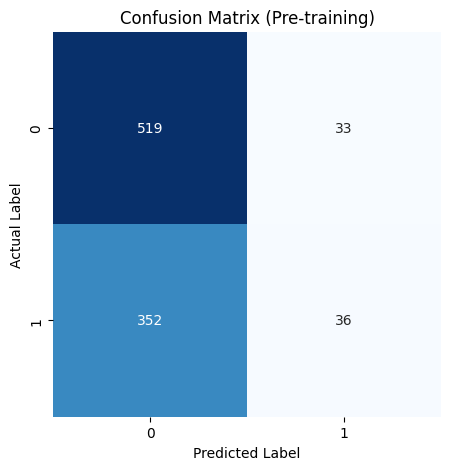

Before training predictions:
 {'test_loss': 0.68760746717453, 'test_model_preparation_time': 0.0019, 'test_accuracy': 0.5904255319148937, 'test_precision': 0.5217391304347826, 'test_recall': 0.09278350515463918, 'test_f1': 0.1575492341356674, 'test_confusion_matrix_00': 519, 'test_confusion_matrix_01': 33, 'test_confusion_matrix_10': 352, 'test_confusion_matrix_11': 36, 'test_runtime': 229.0259, 'test_samples_per_second': 4.104, 'test_steps_per_second': 0.515}


In [ ]:
# Evaluate model without training (for comparison)
predictions_before_training = trainer.predict(tokenized_test)

# Extract true and predicted labels before training
true_labels_pre = predictions_before_training.label_ids
predicted_labels_pre = predictions_before_training.predictions.argmax(-1)

# Compute and plot confusion matrix for pre-training evaluation
cm_pre = confusion_matrix(true_labels_pre, predicted_labels_pre)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_pre, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Pre-training)')
plt.show()

# Print baseline results
print("Before training predictions:\n", predictions_before_training.metrics)

In [ ]:
# Print baseline results
print("Before training predictions:\n", predictions_before_training.metrics)

Before training predictions:
 {'test_loss': 0.68760746717453, 'test_model_preparation_time': 0.0019, 'test_accuracy': 0.5904255319148937, 'test_precision': 0.5217391304347826, 'test_recall': 0.09278350515463918, 'test_f1': 0.1575492341356674, 'test_confusion_matrix_00': 519, 'test_confusion_matrix_01': 33, 'test_confusion_matrix_10': 352, 'test_confusion_matrix_11': 36, 'test_runtime': 229.0259, 'test_samples_per_second': 4.104, 'test_steps_per_second': 0.515}


# 5. Model Training

In [ ]:
# Step 11: Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1,Confusion Matrix 00,Confusion Matrix 01,Confusion Matrix 10,Confusion Matrix 11
1,0.440400,0.462677,0.001900,0.796809,0.751918,0.757732,0.754814,455,97,94,294
2,0.292600,0.563632,0.001900,0.806383,0.784530,0.731959,0.757333,474,78,104,284
3,0.186300,0.811153,0.001900,0.808511,0.795455,0.721649,0.756757,480,72,108,280


TrainOutput(global_step=3360, training_loss=0.30642994926089334, metrics={'train_runtime': 21266.784, 'train_samples_per_second': 1.264, 'train_steps_per_second': 0.158, 'total_flos': 890180918968320.0, 'train_loss': 0.30642994926089334, 'epoch': 3.0})

# 6. Model Evaluation

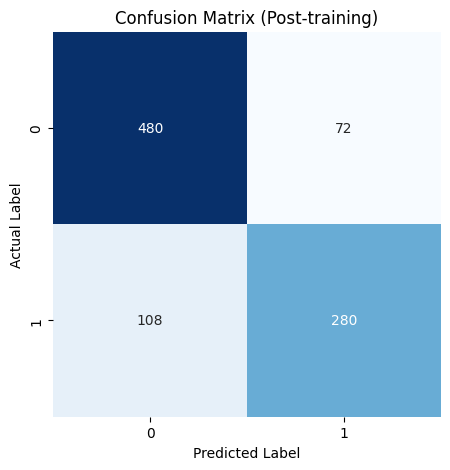

Evaluation results:
 {'eval_loss': 0.8111530542373657, 'eval_model_preparation_time': 0.0019, 'eval_accuracy': 0.8085106382978723, 'eval_precision': 0.7954545454545454, 'eval_recall': 0.7216494845360825, 'eval_f1': 0.7567567567567567, 'eval_confusion_matrix_00': 480, 'eval_confusion_matrix_01': 72, 'eval_confusion_matrix_10': 108, 'eval_confusion_matrix_11': 280, 'eval_runtime': 204.249, 'eval_samples_per_second': 4.602, 'eval_steps_per_second': 0.578, 'epoch': 3.0}


In [ ]:
# Evaluate the model
results = trainer.evaluate()

# Extract confusion matrix components
cm = np.array([[results['eval_confusion_matrix_00'], results['eval_confusion_matrix_01']],
               [results['eval_confusion_matrix_10'], results['eval_confusion_matrix_11']]])

# Visualize the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Post-training)')
plt.show()

# Print final evaluation results
print("Evaluation results:\n", results)

# 7. Model Inference

In [ ]:
# Import torch
import torch

# Perform Inference (Prediction)
texts = ["Here is a good review, you are so nice.", "You are a piece of sh*t."]

# Tokenize the input text for inference
inference_encodings = tokenizer(texts, truncation=True, padding=True, return_tensors='pt')

# Ensure the model is in evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(**inference_encodings)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

# Decode the predictions
labels = ['Non-Toxic', 'Toxic']
predicted_labels = [labels[pred] for pred in predictions]

# Display the inference results
for i, text in enumerate(texts):
    print(f"Text: {text}")
    print(f"Predicted Label: {predicted_labels[i]}\n")


Text: Here is a good review, you are so nice.
Predicted Label: Non-Toxic

Text: You are a piece of sh*t.
Predicted Label: Toxic

